In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
import matplotlib
import torch
from torch import nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float64)

In [ ]:
!git clone https://github.com/numenta/NAB.git

Cloning into 'NAB'...
remote: Enumerating objects: 7035, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 7035 (delta 51), reused 35 (delta 13), pack-reused 6915
Receiving objects: 100% (7035/7035), 86.75 MiB | 20.82 MiB/s, done.
Resolving deltas: 100% (4925/4925), done.
Updating files: 100% (1186/1186), done.


In [ ]:
rawData = pd.read_csv("./NAB/data/artificialWithAnomaly/art_daily_jumpsup.csv")
rawData.head()

,timestamp,value
0,2014-04-01 00:00:00,19.761252
1,2014-04-01 00:05:00,20.500833
2,2014-04-01 00:10:00,19.961641
3,2014-04-01 00:15:00,21.490266
4,2014-04-01 00:20:00,20.187739


In [ ]:
def convertTime(time):
  return datetime.fromisoformat(time)

In [ ]:
data = rawData.copy()

In [ ]:
data["timestamp"] = data["timestamp"].apply(convertTime)

In [ ]:
data = data[["timestamp","value"]]
data.head()

,timestamp,value
0,2014-04-01 00:00:00,19.761252
1,2014-04-01 00:05:00,20.500833
2,2014-04-01 00:10:00,19.961641
3,2014-04-01 00:15:00,21.490266
4,2014-04-01 00:20:00,20.187739


In [ ]:
def convertToFloatMb(x):
  try:
    return float(x) * 1e-6
  except ValueError:
    return 0

In [ ]:
from copy import deepcopy as dc

In [ ]:
from sklearn.preprocessing import MinMaxScaler


def prepare_dataframe_for_lstm(df, n_steps):
  df = dc(df)
  df["value"] =  df["value"].rolling(window=10).mean().dropna()

  scaler = MinMaxScaler()
  scaler.fit(df["value"].values.reshape(-1, 1))

  df["value"] = scaler.transform(df["value"].values.reshape(-1, 1))

  df.set_index("timestamp", inplace=True)

  for i in range(1, n_steps+1):
    df[f"value(t-{i})"] = df["value"].shift(i)

  df.dropna(inplace=True)

  return df, scaler

In [ ]:
shifted_data,scaler = prepare_dataframe_for_lstm(data, 50)

In [ ]:
shifted_data

,value,value(t-1),value(t-2),value(t-3),value(t-4),value(t-5),value(t-6),value(t-7),value(t-8),value(t-9),...,value(t-41),value(t-42),value(t-43),value(t-44),value(t-45),value(t-46),value(t-47),value(t-48),value(t-49),value(t-50)
timestamp,,,,,,,,,,,,,,,,,,,,,
2014-04-01 04:55:00,0.012672,0.011713,0.012685,0.012150,0.011930,0.012273,0.010580,0.010710,0.012053,0.010304,...,0.010124,0.007611,0.009419,0.010142,0.010265,0.010013,0.010954,0.010792,0.010169,0.009144
2014-04-01 05:00:00,0.010956,0.012672,0.011713,0.012685,0.012150,0.011930,0.012273,0.010580,0.010710,0.012053,...,0.011817,0.010124,0.007611,0.009419,0.010142,0.010265,0.010013,0.010954,0.010792,0.010169
2014-04-01 05:05:00,0.011397,0.010956,0.012672,0.011713,0.012685,0.012150,0.011930,0.012273,0.010580,0.010710,...,0.011356,0.011817,0.010124,0.007611,0.009419,0.010142,0.010265,0.010013,0.010954,0.010792
2014-04-01 05:10:00,0.012091,0.011397,0.010956,0.012672,0.011713,0.012685,0.012150,0.011930,0.012273,0.010580,...,0.009820,0.011356,0.011817,0.010124,0.007611,0.009419,0.010142,0.010265,0.010013,0.010954
2014-04-01 05:15:00,0.009733,0.012091,0.011397,0.010956,0.012672,0.011713,0.012685,0.012150,0.011930,0.012273,...,0.008683,0.009820,0.011356,0.011817,0.010124,0.007611,0.009419,0.010142,0.010265,0.010013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-04-14 23:35:00,0.003486,0.006216,0.008157,0.010849,0.009266,0.010447,0.012114,0.011274,0.011843,0.011973,...,0.021010,0.024700,0.025874,0.025295,0.025674,0.025304,0.035524,0.042048,0.049212,0.056467
2014-04-14 23:40:00,0.004224,0.003486,0.006216,0.008157,0.010849,0.009266,0.010447,0.012114,0.011274,0.011843,...,0.018958,0.021010,0.024700,0.025874,0.025295,0.025674,0.025304,0.035524,0.042048,0.049212
2014-04-14 23:45:00,0.005380,0.004224,0.003486,0.006216,0.008157,0.010849,0.009266,0.010447,0.012114,0.011274,...,0.017797,0.018958,0.021010,0.024700,0.025874,0.025295,0.025674,0.025304,0.035524,0.042048


In [ ]:
numpy_shifted_data = shifted_data.to_numpy()

In [ ]:
X = dc(np.flip(numpy_shifted_data[:,1:],axis=1))
y = numpy_shifted_data[:,0]

In [ ]:
X,y

(array([[0.00914366, 0.01016929, 0.01079222, ..., 0.01214987, 0.01268495,
         0.0117131 ],
        [0.01016929, 0.01079222, 0.01095422, ..., 0.01268495, 0.0117131 ,
         0.01267235],
        [0.01079222, 0.01095422, 0.01001347, ..., 0.0117131 , 0.01267235,
         0.01095593],
        ...,
        [0.04204756, 0.03552393, 0.02530359, ..., 0.00621592, 0.00348551,
         0.00422387],
        [0.03552393, 0.02530359, 0.02567394, ..., 0.00348551, 0.00422387,
         0.00538032],
        [0.02530359, 0.02567394, 0.025295  , ..., 0.00422387, 0.00538032,
         0.00384418]]),
 array([0.01267235, 0.01095593, 0.01139662, ..., 0.00538032, 0.00384418,
        0.00545564]))

In [ ]:
split_index = int(len(X)*0.10)

In [ ]:
X_train = X[:split_index].reshape(-1,50,1)
y_train = y[:split_index].reshape(-1,1)

X_test = X[split_index:].reshape(-1,50,1)
y_test = y[split_index:].reshape(-1,1)

In [ ]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    return self.X[index], self.y[index]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [ ]:
from torch.utils.data import DataLoader

batch_size = 30

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
for _, batch in enumerate(train_loader):
  x_batch,y_batch = batch[0].to(device), batch[1].to(device)
  print(x_batch.shape, y_batch.shape)
  break

torch.Size([30, 50, 1]) torch.Size([30, 1])


In [ ]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers):
    super(LSTM, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers

    self.sq = nn.Sequential()
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, 1)


  def forward(self, x):
    batch_size = x.size(0)

    h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
    c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

    out, _ = self.lstm(x, (h0, c0))
    out = self.fc(out[:, -1, :])

    return out

In [ ]:
model = LSTM(1,30, 2)
model.to(device)
model

LSTM(
  (sq): Sequential()
  (lstm): LSTM(1, 30, num_layers=2, batch_first=True)
  (fc): Linear(in_features=30, out_features=1, bias=True)
)

In [ ]:
import math

In [ ]:
def test_one_epoch(loss_fn):
  running_loss = 0.0
  model.eval()

  for batch_index, batch in enumerate(test_loader):
      x_batch, y_batch = batch[0].to(device), batch[1].to(device)

      with torch.no_grad():

        output = model(x_batch)
        loss = loss_fn(output,y_batch)
        running_loss += loss

  avg_loss_for_batch = running_loss / len(test_loader)
  print(f"Test Loss: {avg_loss_for_batch}")

  print()

In [ ]:
def train_one_epoch(loss_fn):
  running_loss = 0.0
  model.train()
  errors = []
  for batch_index, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    output = model(x_batch)
    loss = loss_fn(output,y_batch)
    running_loss += loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    errors.append(loss.item())

    if batch_index % 10 == 0:
      avg_loss_for_batch = running_loss / 10
      print(f"Batch: {batch_index} Loss: {avg_loss_for_batch:0.3f}")
      running_loss = 0.0
  return errors

In [ ]:
learning_rate = 0.01
num_epochs = 20
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

lastEpochErrors = []

for epoch in range(num_epochs):
    print("Epoch: ", epoch)
    lastEpochErrors = train_one_epoch(loss_fn)
    test_one_epoch(loss_fn)
    print("\n\n")

Epoch:  0
Batch: 0 Loss: 0.002
Batch: 10 Loss: 0.021
Test Loss: 0.11142164499495823




Epoch:  1
Batch: 0 Loss: 0.000
Batch: 10 Loss: 0.078
Test Loss: 0.05018711211748882




Epoch:  2
Batch: 0 Loss: 0.002
Batch: 10 Loss: 0.046
Test Loss: 0.02132307341746757




Epoch:  3
Batch: 0 Loss: 0.001
Batch: 10 Loss: 0.010
Test Loss: 0.04909052542126099




Epoch:  4
Batch: 0 Loss: 0.000
Batch: 10 Loss: 0.033
Test Loss: 0.017238502953719356




Epoch:  5
Batch: 0 Loss: 0.001
Batch: 10 Loss: 0.009
Test Loss: 0.007472271054251344




Epoch:  6
Batch: 0 Loss: 0.000
Batch: 10 Loss: 0.003
Test Loss: 0.005446290794856925




Epoch:  7
Batch: 0 Loss: 0.000
Batch: 10 Loss: 0.002
Test Loss: 0.0059586683824136375




Epoch:  8
Batch: 0 Loss: 0.000
Batch: 10 Loss: 0.002
Test Loss: 0.004766501424262945




Epoch:  9
Batch: 0 Loss: 0.000
Batch: 10 Loss: 0.001
Test Loss: 0.0046240456651081285




Epoch:  10
Batch: 0 Loss: 0.000
Batch: 10 Loss: 0.001
Test Loss: 0.004338109844830637




Epoch:  11
Batch: 0 Lo

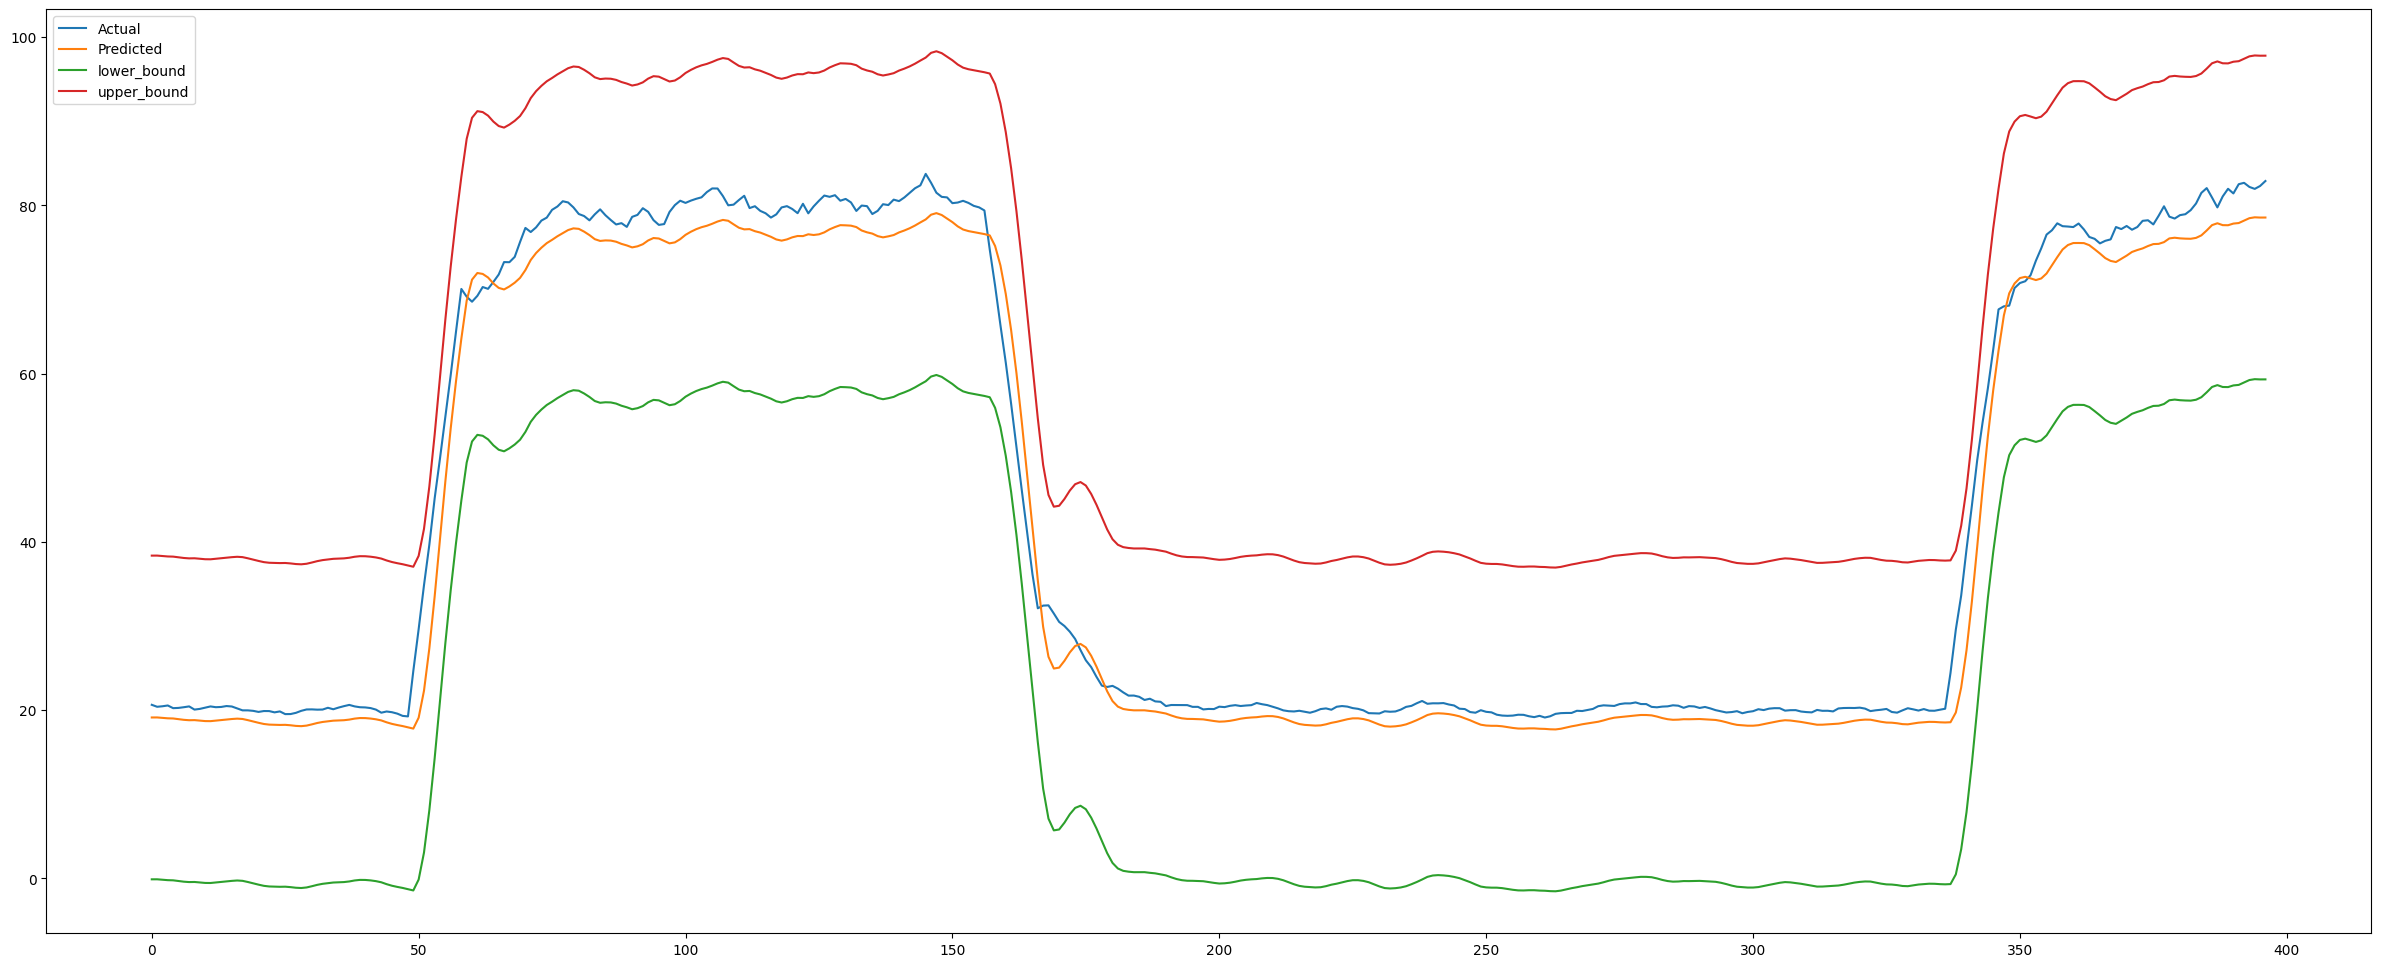

In [ ]:
with torch.no_grad():
  predicted = scaler.inverse_transform(model(torch.from_numpy(X_train).to(device)).to("cpu"))


actual_values = scaler.inverse_transform(y_train)
errors = actual_values - predicted

error_mean = np.mean(errors)
error_std = np.std(errors)

threshold = scaler.inverse_transform([[math.sqrt(np.array(lastEpochErrors).min())]])

lower_bound = predicted - threshold
upper_bound = predicted + threshold

plt.clf()
plt.close()
plt.figure(figsize=(30, 12))
plt.plot(pd.DataFrame(actual_values.flatten()), label='Actual')
plt.plot(predicted, label='Predicted')

plt.plot(lower_bound, label='lower_bound')
plt.plot(upper_bound, label='upper_bound')

plt.legend()
plt.show()

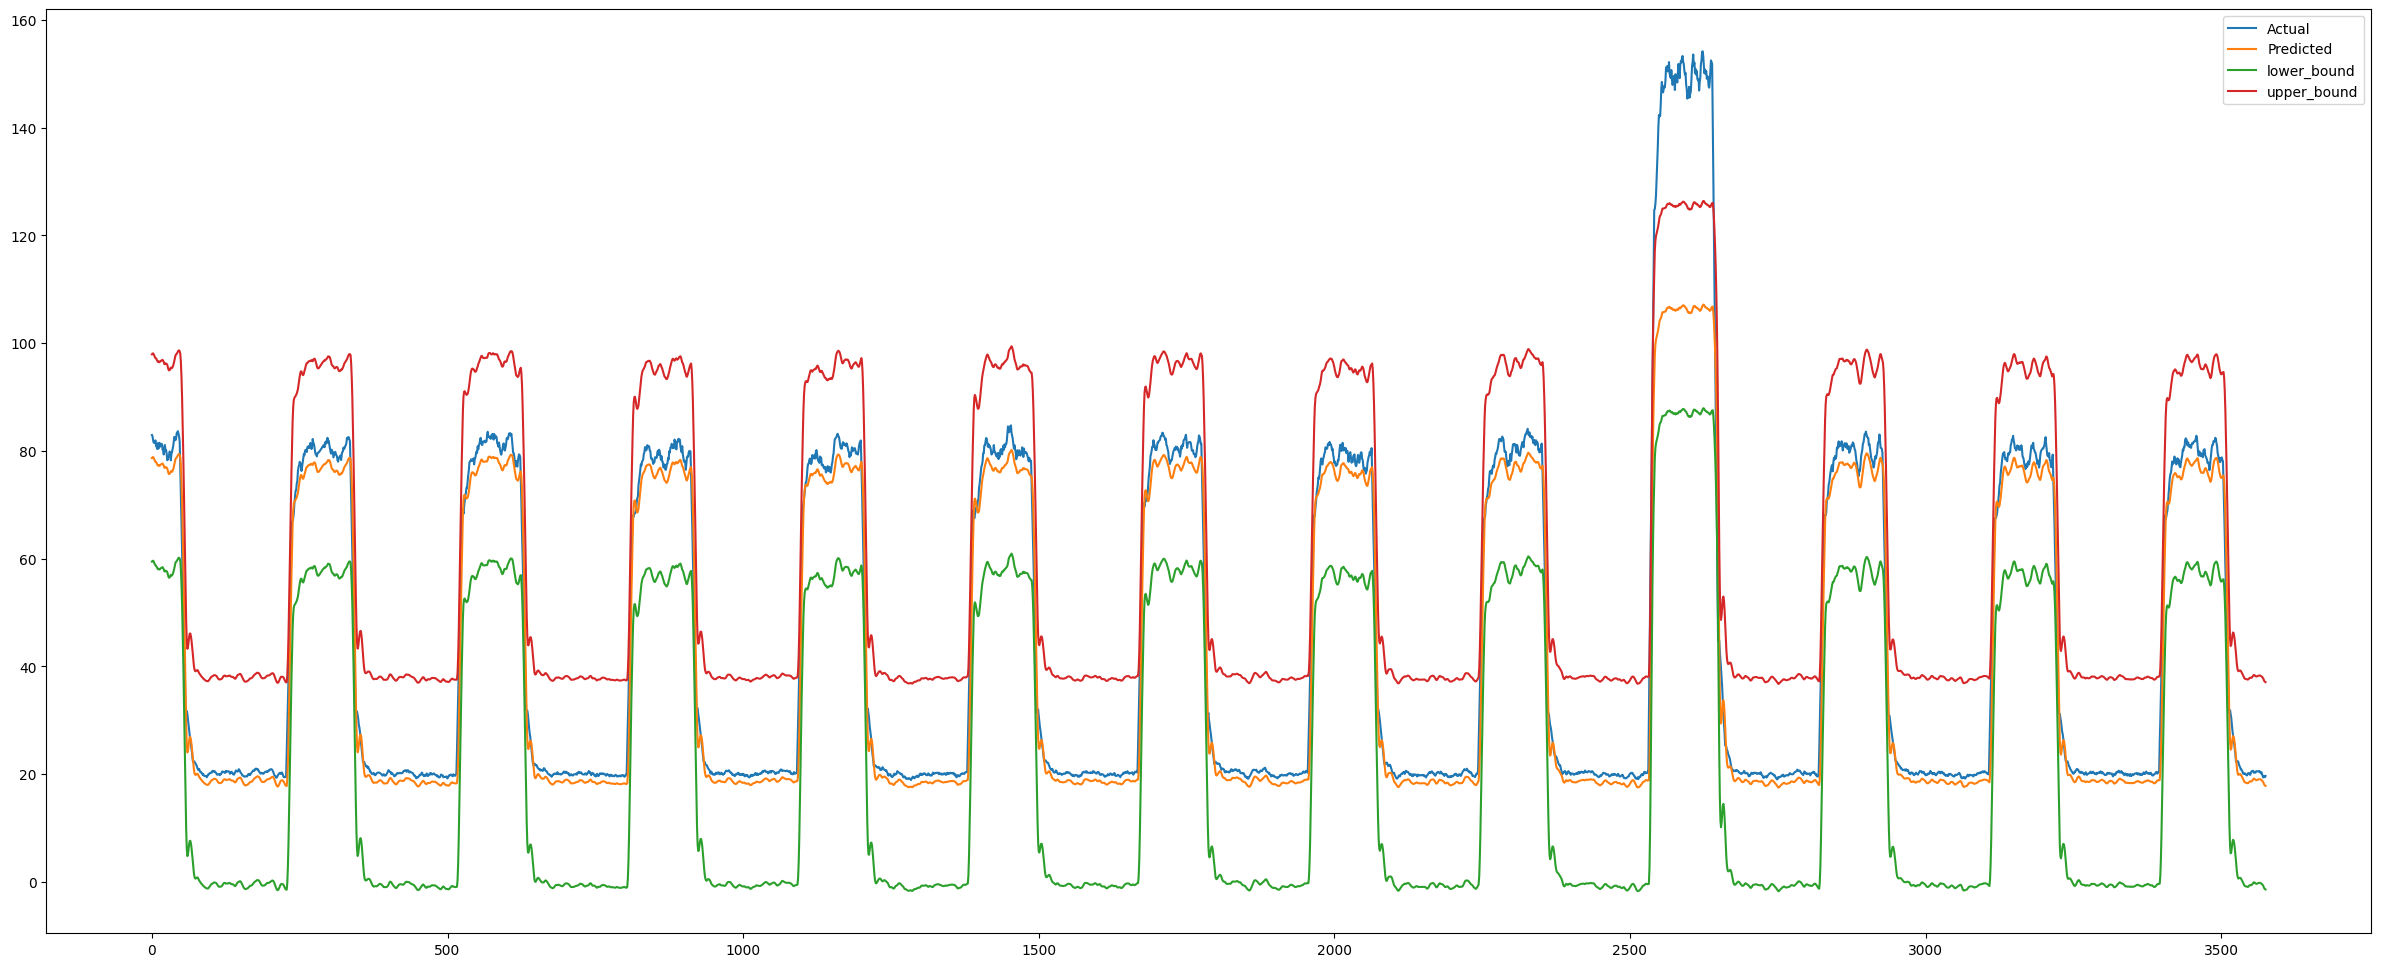

In [ ]:
with torch.no_grad():
  predicted_test = scaler.inverse_transform(model(torch.from_numpy(X_test).to(device)).to("cpu"))


actual_values = scaler.inverse_transform(y_test)
errors = actual_values - predicted_test

error_mean = np.mean(errors)
error_std = np.std(errors)

# threshold = error_mean + 1.96 * error_std

lower_bound_test = predicted_test - threshold
upper_bound_test = predicted_test +  threshold

plt.clf()
plt.close()
plt.figure(figsize=(30, 12))
plt.plot(pd.DataFrame(actual_values.flatten()), label='Actual')
plt.plot(predicted_test, label='Predicted')

plt.plot(lower_bound_test, label='lower_bound')
plt.plot(upper_bound_test, label='upper_bound')

plt.legend()
plt.show()

### Calculate MSE lost on Test Data

In [ ]:
test_loss_fn = nn.MSELoss()
print("Root Mean Squred Error:",math.sqrt(test_loss_fn(torch.tensor(predicted_test), torch.tensor(actual_values))))

Root Mean Squred Error: 7.808595406375921


In [ ]:
from sklearn.metrics import r2_score

print("Root Mean Squred Error:",r2_score(actual_values, predicted_test))

Root Mean Squred Error: 0.9414003661418106


In [ ]:
from sklearn.metrics import r2_score

print("Root Mean Squred Error On train:",r2_score(scaler.inverse_transform(y_train), predicted))

Root Mean Squred Error On train: 0.986178928298409


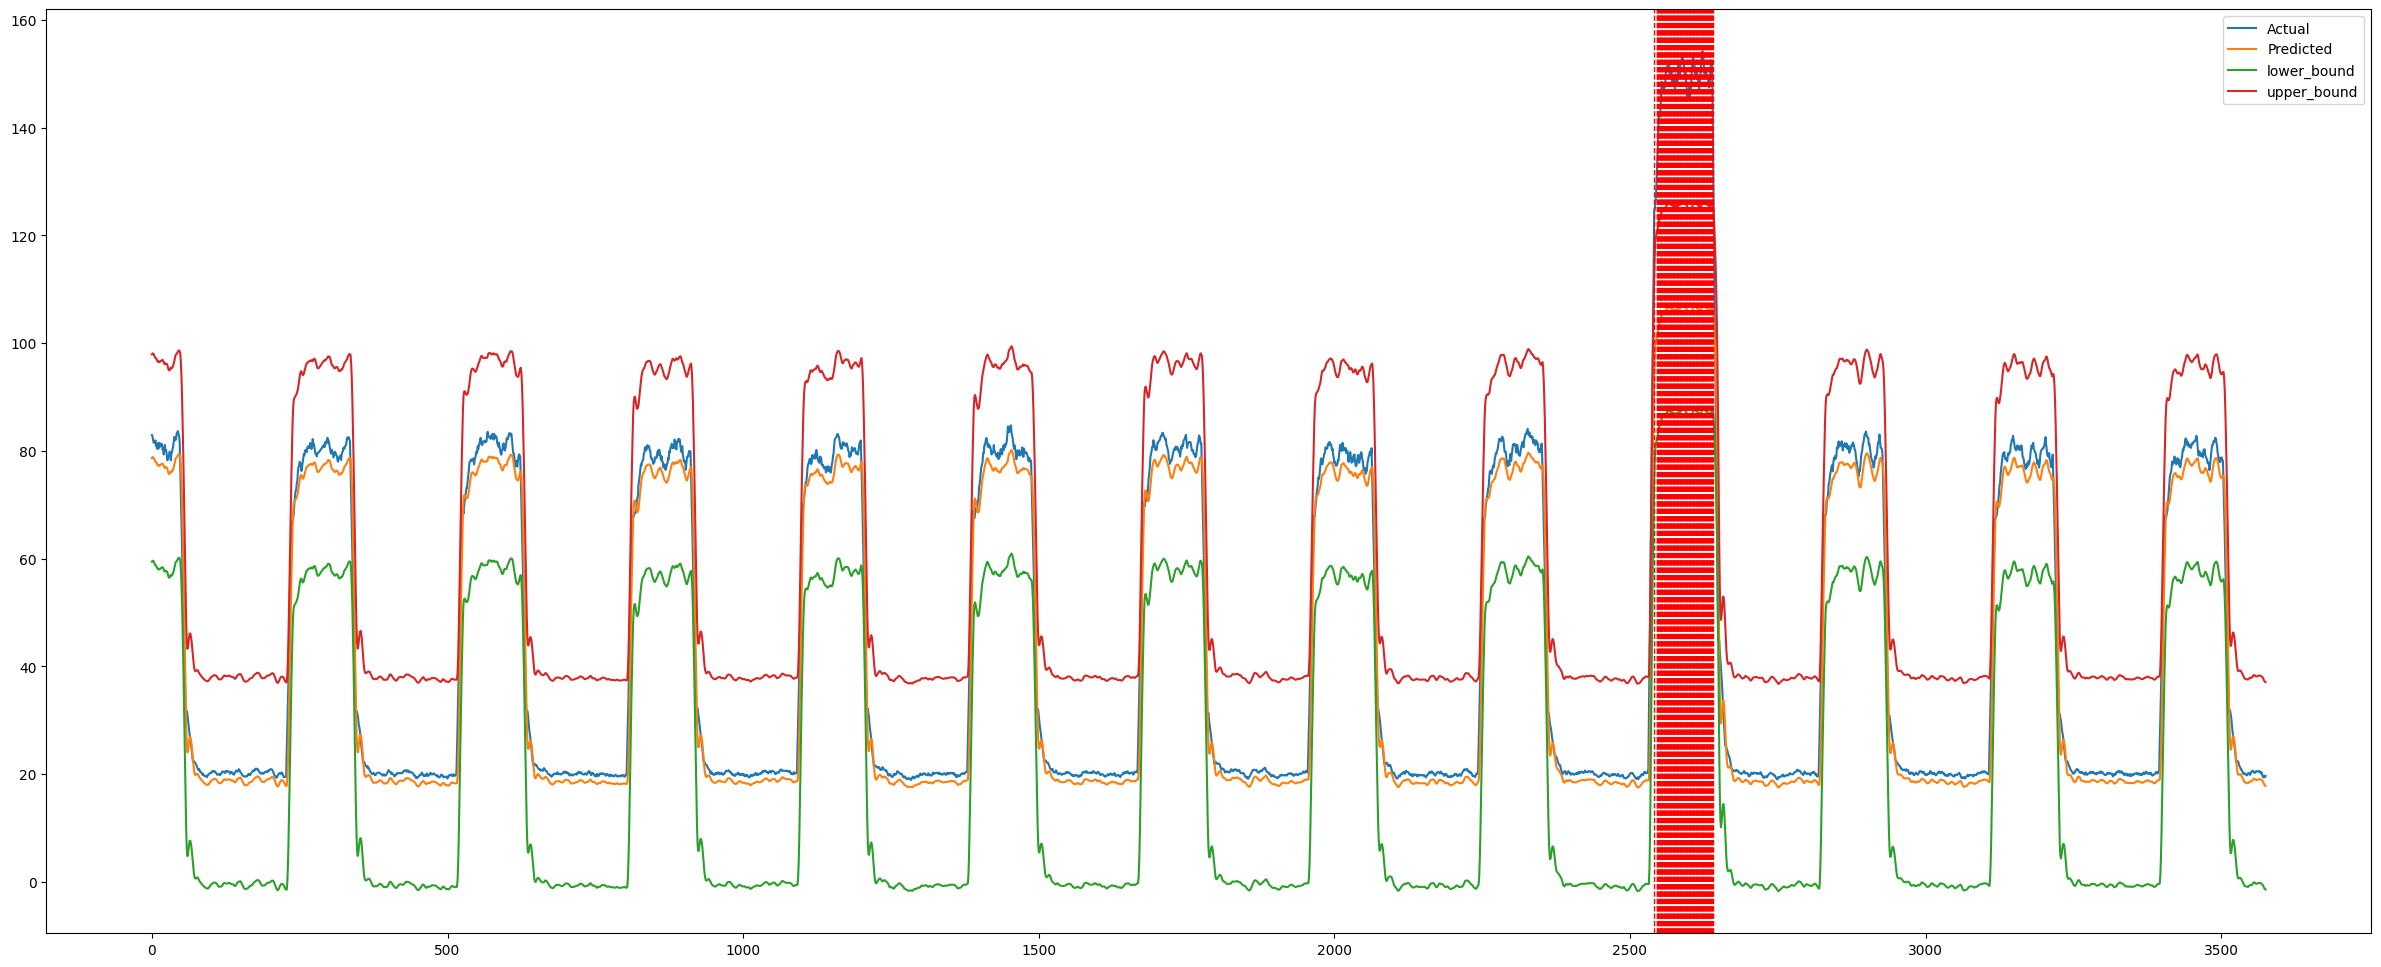

In [ ]:
# prompt: Detect windows that are out of the threshold interval range and mark them as anomaly(actual data is anomaly), and plot the detected windows. add drop and increase threshold. revese the scale transformation

import pandas as pd
import matplotlib.pyplot as plt
def detect_anomalies(predicted, lower_bound, upper_bound, actual_values, drop=0, increase=0):
  anomalies = []
  for i in range(len(predicted)):
    if actual_values[i] < lower_bound[i] - drop or actual_values[i] > upper_bound[i] + increase:
      anomalies.append(i)
  return anomalies

anomalies = detect_anomalies(predicted_test, lower_bound_test, upper_bound_test, actual_values, drop=30, increase=10)

plt.clf()
plt.close()
plt.figure(figsize=(30, 12))
plt.plot(pd.DataFrame(actual_values.flatten()), label='Actual')
plt.plot(predicted_test, label='Predicted')

plt.plot(lower_bound_test, label='lower_bound')
plt.plot(upper_bound_test, label='upper_bound')

for anomaly in anomalies:
  plt.axvline(x=anomaly, color='r', linestyle='--', linewidth=1)

plt.legend()
plt.show()
